# 6 minutes pour entrainer un réseau de neurones à distinguer un chien d'un chat !

Le but de ce petit notebook est de présenter un exercice de classification d'images avec Keras/TensorFlow. Pour ce faire, nous utiliserons Jupyter (of course), une partie du dataset Kaggle Cats vs Dogs (2 classes d'images) et différentes architectures de CNN.

Nous nous basons en grande partie sur l'excellent tutoriel de François Chollet, auteur de Keras, et accessible ici : https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

Le pari ? Après quelques introductions et expérimentations, il ne faudra que 6 minutes pour entrainer un réseau de neurones convolitif à distinguer un chien d'un chat, **avec seulement 1000 images d'exemple de chaque**.

C'est parti !

In [261]:
# Voici les éléments que l'on retrouvera dans la quasi-totalité de nos exercices
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [262]:
# ...et nous importons les bibliothèques nécessaires.
import keras


## Préparation du dataset
La première tâche consiste à récupérer le data set et l'organiser correctement.

On commence donc par télécharger le dataset (nous fournissons un petit exemple sous forme d'un ZIP facilement récupérable avec `wget`).

Initialement issu de Kaggle, nous travaillerons avec un dataset réduit d'environ 1000 images.
Au final, nous aurons un dataset contenant :
```data/
    train/
        dogs/
            dog001.jpg
            dog002.jpg
            ...
        cats/
            cat001.jpg
            cat002.jpg
            ...
    validation/
        dogs/
            dog001.jpg
            dog002.jpg
            ...
        cats/
            cat001.jpg
            cat002.jpg
            ...```

In [263]:
!mkdir -p /tmp/cats_vs_dogs
!mkdir -p /tmp/cats_vs_dogs/models
!wget --no-verbose http://www.ncu.be.s3.amazonaws.com/datascience/cats-vs-dogs-1000/cats_vs_dogs.zip -O ./cats_vs_dogs.zip
!unzip -q -o ./cats_vs_dogs.zip -d /tmp/

2018-07-22 23:21:09 URL:http://www.ncu.be.s3.amazonaws.com/datascience/cats-vs-dogs-1000/cats_vs_dogs.zip [63651116/63651116] -> "./cats_vs_dogs.zip" [1]


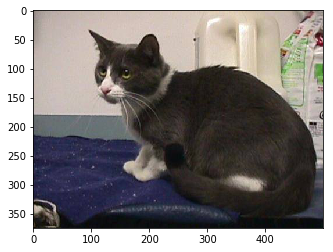

In [264]:
# Et si l'on regardait une image pour vérifier que tout se passe bien ?
from keras.preprocessing.image import load_img
from matplotlib.pyplot import imshow
import numpy as np
img = load_img('/tmp/cats_vs_dogs/train/cats/cat.4.jpg')
imshow(np.asarray(img))
#img = load_img('/tmp/cats_vs_dogs/train/dogs/dog.1284.jpg')
#imshow(np.asarray(img))

Bon, ça ressemble à un chat, tout va bien !

Les images ne sont pas normalisées, et avec un dataset aussi "faible", nous aurons du mal à entrainer un CNN de toutes façons.
Il faut donc effectuer un pré-processing des images pour :

* Normaliser le dataset (notamment largeur / hauteur)

* Augmenter la dataset

Nous allons utiliser les fonctions présentes dans Keras pour cela. L'objectif est une augmentation de **facteur 20** du dataset pour des images d'une dimension de **150x150 pixels**.

Voici un premier exemple pour comprendre rapidement comment fonctionne l'augmentation.

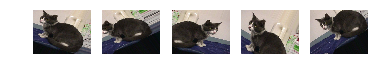

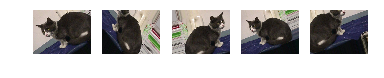

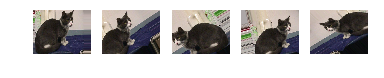

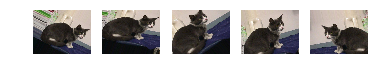

In [265]:
!rm -rf /tmp/cats_vs_dogs/preview
!mkdir -p /tmp/cats_vs_dogs/preview
import os
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

img = load_img('/tmp/cats_vs_dogs/train/cats/cat.4.jpg')  # this is a PIL image
x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)

# the .flow() command below generates batches of randomly transformed images
# and saves the results to the `preview/` directory
i = 0
for batch in datagen.flow(x, batch_size=1,
                          save_to_dir='/tmp/cats_vs_dogs/preview', save_prefix='cat', save_format='jpeg'):
    i += 1
    if i >= 20:
        break  # otherwise the generator would loop indefinitely

# Display images horizontally
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure, imshow, axis
from matplotlib.image import imread

def showImagesHorizontally(list_of_files):
    fig = figure()
    number_of_files = len(list_of_files)
    for i in range(number_of_files):
        a=fig.add_subplot(1,number_of_files,i+1)
        if isinstance(list_of_files[i], str):
            image = imread(list_of_files[i])
        else:
            image = list_of_files[i]
        imshow(image,cmap='Greys_r')
        axis('off')

def iter_batch(iterable, n=1):
    l = len(iterable)
    for ndx in range(0, l, n):
        yield iterable[ndx:min(ndx + n, l)]
        
preview_images = [ os.path.join('/tmp/cats_vs_dogs/preview', f) for f in os.listdir('/tmp/cats_vs_dogs/preview') ]
for preview_batch in iter_batch(preview_images, 5):
    showImagesHorizontally(preview_batch)

Ça a l'air pas mal ! 1 chat devient 20 chats... En pratique, cette augmentation de données se fera "in-place", c'est à dire directement dans le générateur d'images et sans avoir besoin d'enregistrer un fichier sur le disque.

In [266]:
batch_size = 16
train_dir = '/tmp/cats_vs_dogs/train'
validation_dir = '/tmp/cats_vs_dogs/validation'

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# this is a generator that will read pictures found in
# subfolers of 'data/train', and indefinitely generate
# batches of augmented image data
def get_generators(img_width=150, img_height=150):
    train_generator = train_datagen.flow_from_directory(
            train_dir,
            target_size=(img_width, img_height),  # all images will be resized to 150x150
            batch_size=batch_size,
            class_mode='binary')  # since we use binary_crossentropy loss, we need binary labels

    # this is a similar generator, for validation data
    validation_generator = test_datagen.flow_from_directory(
            validation_dir,
            target_size=(img_width, img_height),
            batch_size=batch_size,
            #shuffle=False,         # We disable shuffling
            class_mode='binary')
    return train_generator, validation_generator
    
train_generator, validation_generator = get_generators()

Found 2000 images belonging to 2 classes.
Found 802 images belonging to 2 classes.


Found 2 images belonging to 2 classes.


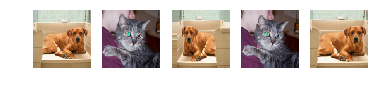

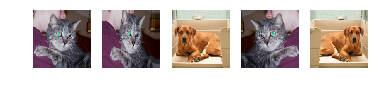

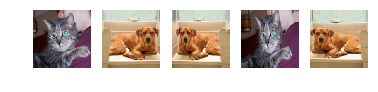

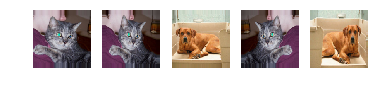

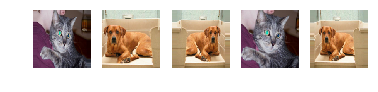

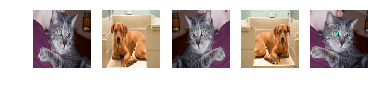

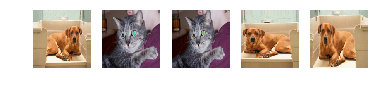

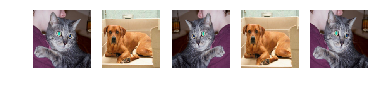

In [267]:
# On valide, comme d'habitude, que nos données sont cohérentes, 
# par exemple en affichant les premières images du generator.
# J'aime bien avoir un répertoire "minival" qui permet de "jouer" avec très peu d'images,
# cela me sert notamment à overfitter le CNN avant de l'entrainer sur un jeu de données plus important.
# Utilisons ce petit répertoire pour vérifier le comportement de notre générateur !
mini_generator = train_datagen.flow_from_directory(
        '/tmp/cats_vs_dogs/minival',
        target_size=(150, 150),  # all images will be resized to 150x150
        batch_size=batch_size,
        class_mode='binary')  # since we use binary_crossentropy loss, we need binary labels

import itertools
preview_images = []
for preview_image_batch in list(itertools.islice(mini_generator, 0, 20)):
    for batch_image in preview_image_batch[0]:
        preview_images.append(batch_image)
for preview_batch in iter_batch(preview_images, 5):
    showImagesHorizontally(preview_batch)


# Un premier réseau de neurones à convolution

Maintenant, que nous avons des données cohérentes (et augmentées !), nous construisons un premier réseau de convolution pour traiter ces images de 150x150x3.

Un petit réseau, une dizaine de couches profondes, rien de bien compliqué.

In [268]:
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import optimizers

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(150, 150, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# the model so far outputs 3D feature maps (height, width, features)

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])


In [269]:
# ...Et c'est parti pour le premier entrainement !!
# On sauvegarde les poids à la fin, 
train_generator, validation_generator = get_generators()
history = model.fit_generator(
        train_generator,
        steps_per_epoch=2000 // batch_size,
        epochs=50,
        validation_data=validation_generator,
        validation_steps=800 // batch_size)
model.save_weights('/tmp/cats_vs_dogs/models/conv_v1.h5')

Found 2000 images belonging to 2 classes.
Found 802 images belonging to 2 classes.
Epoch 1/50
125/125 [==============================] - 27s 213ms/step - loss: 0.7285 - acc: 0.5270 - val_loss: 0.6892 - val_acc: 0.5500
Epoch 2/50
125/125 [==============================] - 25s 197ms/step - loss: 0.6875 - acc: 0.5645 - val_loss: 0.6432 - val_acc: 0.6575
Epoch 3/50
125/125 [==============================] - 25s 197ms/step - loss: 0.6613 - acc: 0.6250 - val_loss: 0.6112 - val_acc: 0.6813
Epoch 4/50
125/125 [==============================] - 25s 196ms/step - loss: 0.6344 - acc: 0.6665 - val_loss: 0.5838 - val_acc: 0.6825
Epoch 5/50
125/125 [==============================] - 25s 198ms/step - loss: 0.6027 - acc: 0.6835 - val_loss: 0.5522 - val_acc: 0.7100
Epoch 6/50
125/125 [==============================] - 24s 196ms/step - loss: 0.5914 - acc: 0.6920 - val_loss: 0.5205 - val_acc: 0.7450
Epoch 7/50
125/125 [==============================] - 25s 199ms/step - loss: 0.5577 - acc: 0.7110 - val_los

25 secondes par epoch environ, cela nous fait à peu près 20 minutes d'entrainement sur un GPU (merci Crestle).

Si vous êtes impatients, vous pouvez vous contenter de 5 epoch et continuer la suite de ce document — les performances seront juste moins bonnes mais la logique reste la même.

Cela dit, nous atteignons en 20 minutes une précision de près de 80%... à vrai dire, ce n'est pas si mal pour un début.

Mais avant de poursuivre, il nous faut valider le modèle et l'apprentissage. Est-ce que l'on converge bien, déjà ?

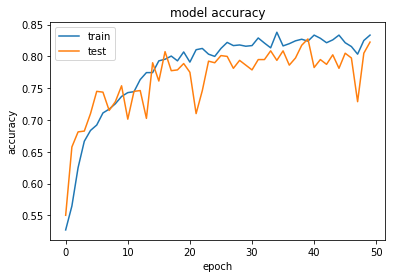

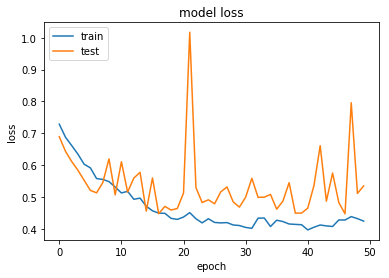

In [270]:
def plot_model_curves():
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
plot_model_curves()

On dirait bien. L'accuracy monte et atteint un plateau, tandis que l'erreur continue de baisser.

Avant de poursuivre, validons rapidement "à vue de nez" notre modèle en testant sur quelques images au hasard. Pour mémoire, la prédiction est de 0 pour un chat et 1 pour un chien (cat < dog en ordre alpha)

array([[0.]], dtype=float32)

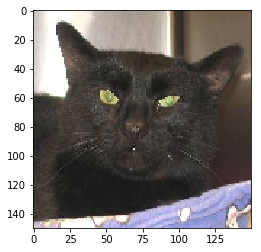

In [271]:
model.load_weights('/tmp/cats_vs_dogs/models/conv_v1.h5')
img = load_img(
    '/tmp/cats_vs_dogs/validation/cats/cat.1016.jpg',
#    '/tmp/cats_vs_dogs/validation/dogs/dog.5053.jpg',
    target_size=(150, 150)
)
x = np.asarray(img)
imshow(x)
x = np.expand_dims(x, axis=0)
model.predict(x)
# Normalement, cat=0 et dog=1



Et maintenant, nous construisons une matrice de confusion autour des données générées.

La méthode peut sembler ici un peu fastidieuse car nous reconstruisons batch par batch un ensemble de données. Nous aurions pu aussi faire en sorte que le validation_generator ne génère pas les images en ordre aléatoire, mais cela aurait pu nuire à la qualité de l'entrainement. Aussi, nous préférons renconstruire une matrice `(image, ground_truth)`.

In [272]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score
def get_confusion_matrix():
    n_test_samples = 800
    n_train_samples = 2000
    validation_batches = list(itertools.islice(validation_generator, 0, n_test_samples // batch_size))
    val_images = None
    val_truth = np.array([])
    val_predictions = np.array([])
    for validation_batch in validation_batches:
        # validation_batch[0] are the <batch_size> images
        # validation_batch[1] are the <batch_size> ground truth classes
        if val_images is None:
            val_images = validation_batch[0]
        else:
            val_images = np.concatenate((val_images, validation_batch[0]))
        val_truth = np.concatenate((val_truth, validation_batch[1].ravel()))
        val_predictions = np.concatenate((
            val_predictions,
            np.around(model.predict(validation_batch[0]).ravel()),
        ))
    return confusion_matrix(val_truth, val_predictions)

def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    """
    print(cm)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    


tn: 300 fp: 99 fn: 43 tp: 358
[[300  99]
 [ 43 358]]


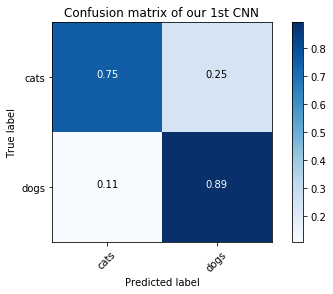

In [273]:
confusion = get_confusion_matrix()
tn, fp, fn, tp = confusion.ravel()
print("tn:", tn, "fp:", fp, "fn:", fn, "tp:", tp)
#print("F1 score", f1_score(val_truth, val_predictions))

plot_confusion_matrix(
    confusion, 
    classes=('cats', 'dogs'),
    title='Confusion matrix of our 1st CNN')


## La magie du transfer learning
Nous allons maintenant utiliser la technique du *transfer learning* pour entrainer un nouveau CNN. L'idée est de partir d'un CNN déjà entrainé, dans notre cas VGG16 entrainé avec Resnet, afin de se baser sur les features déjà apprises et de spécialiser simplement les couches supérieures du réseau. 

C'est parti !

In [275]:
from keras import applications

# Importe et "gèle" le modèle VGG16
vgg_model = applications.VGG16(weights='imagenet', input_shape = (224,224,3), include_top=False)
for layer in model.layers[:25]:
    layer.trainable = False

# On construit un classifier par dessus le CNN de VGG16 (sans les couches supérieures)
x = vgg_model.output
x = Flatten()(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation="sigmoid")(x)


# Compile le modèle ainsi construit, optimizer = adam
model = Model(inputs=vgg_model.input, outputs=predictions)
model.compile(loss='binary_crossentropy',
#              optimizer='Adam',
              optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

# On récupère les générateurs (avec la bonne taille d'image, VGG utilise 224x224 pixels)
train_generator, validation_generator = get_generators(224, 224)

# Et entraine le modèle!
history = model.fit_generator(
    train_generator,
    steps_per_epoch=2000 // batch_size,
    epochs=5,
    validation_data=validation_generator,
    validation_steps=800 // batch_size,
#    nb_val_samples=n_test_samples
)
model.save_weights('/tmp/cats_vs_dogs/models/conv_vgg_v1.h5')

Found 2000 images belonging to 2 classes.
Found 802 images belonging to 2 classes.
Epoch 1/5
125/125 [==============================] - 69s 555ms/step - loss: 0.5714 - acc: 0.6880 - val_loss: 0.2750 - val_acc: 0.9225
Epoch 2/5
125/125 [==============================] - 67s 536ms/step - loss: 0.2651 - acc: 0.8985 - val_loss: 0.1341 - val_acc: 0.9575
Epoch 3/5
125/125 [==============================] - 67s 537ms/step - loss: 0.1704 - acc: 0.9330 - val_loss: 0.0927 - val_acc: 0.9725
Epoch 4/5
125/125 [==============================] - 67s 537ms/step - loss: 0.1420 - acc: 0.9405 - val_loss: 0.0863 - val_acc: 0.9700
Epoch 5/5
125/125 [==============================] - 67s 537ms/step - loss: 0.1036 - acc: 0.9590 - val_loss: 0.0641 - val_acc: 0.9800


**Hein ?! Moins de 6 minutes pour arriver à 97% d'accuracy sur le validation set, avec seulement 2000 images??**

Ça semble trop beau pour être vrai !! Et d'ailleurs, il va falloir maintenant valider tout cela ! Même si les chiffres d'évaluation du modèle semblent très prometteurs, il ne faut jamais s'y arrêter et toujours remettre en doute son propre travail...

Donc :
1. On regarde l'évolution des coubes du modèle. Ça doit converger !
2. On évalue le modèle sur quelques images au hasard
3. On calcule la matrice de confusion (puisque nous sommes sur de la classification)

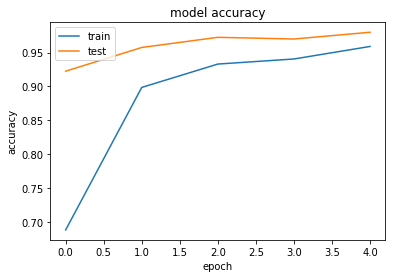

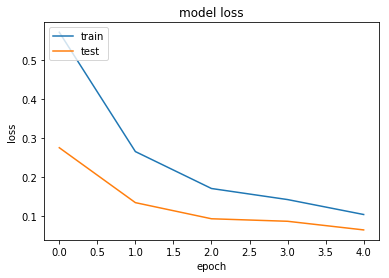

In [276]:
plot_model_curves()


array([[1.]], dtype=float32)

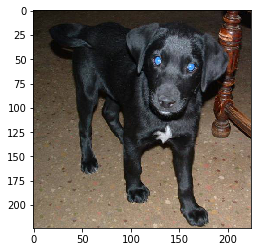

In [277]:
model.load_weights('/tmp/cats_vs_dogs/models/conv_vgg_v1.h5')
img = load_img(
#    '/tmp/cats_vs_dogs/validation/cats/cat.1016.jpg',
    '/tmp/cats_vs_dogs/validation/dogs/dog.5053.jpg',
    target_size=(224, 224)
)
x = np.asarray(img)
imshow(x)
x = np.expand_dims(x, axis=0)
model.predict(x)
# Normalement, cat=0 et dog=1


tn: 394 fp: 5 fn: 11 tp: 390
[[394   5]
 [ 11 390]]


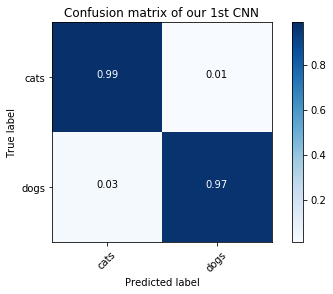

In [278]:
confusion = get_confusion_matrix()
tn, fp, fn, tp = confusion.ravel()
print("tn:", tn, "fp:", fp, "fn:", fn, "tp:", tp)
#print("F1 score", f1_score(val_truth, val_predictions))

plot_confusion_matrix(
    confusion, 
    classes=('cats', 'dogs'),
    title='Confusion matrix of our 1st CNN')


## Conclusion
Avec peu d'efforts, nous sommes arrivés à un score de pertinence de 97% (!), en seulement 10 epoch de VGG16. Notre réseau convolitif converge très vite dans la mesure où VGG a déjà été entrainé sur des chiens et des chats, et donc comporte toutes les features utiles pour discriminer Fido de Félix.

### Puissance et limites de l'exercice
Ce petit exercice montre à quel point une stratégie de transfer learning peut se révéler diablement efficace lorsqu'un réseau neuronal a été entrainé sur un problème similaire.

Bien sûr, si nous avions dû détecter des cellules sanguines avec une accuracy pareille sur la base de VGG16, nous nous serions à coup sûr cassé les dents !

### Pour aller plus loin
On pourrait continuer l'exercice notamment en comparant la performance de l'algorithme suivant le nombre de couches entrainées (freezées).

Il serait intéressant aussi, au delà de l'exercice présenté sous forme d'un tableau Jupyter tout joli, de consigner toutes ces expériences dans un cahier d'expérimentations, un peu de méthodologie ne fait jamais de mal...

Bref, chien ou chat... La prochaine fois, nous entrainerons des objets qui ne faisaient pas partie des jeux d'entrainement de VGG16 sur Imagenet !